# Energy guided EOT (generalization)
**author**: *Sergey Karpukhin*, sergey.karpukhin@skoltech.ru tg: @hr3nk

## 1. Theory

### 1.1 Energy Based Models

#### Definition

Our desire is to sample from true data distribution $p(x)$, but since we don't have access to all possible data $X$, we are limited to approximating true data distribution with model $p_\theta(x)$. EBM is a way to learn such approximation.

Let $E_\theta: \mathbb{R}^D \rightarrow \mathbb{R^{+}}$ be a neural network that maps data to scalar values greater or equal then zero. This neural network will be called *energy function*. Then we can define model of our probability distribution on our data as following:

$$
p_\theta(x) = \frac{1}{z_\theta} \exp(-E_\theta(x)),
$$

where $z_\theta$ is a normalization constant equial to $\int_X \exp(-E_\theta(x)) \mathrm{d}x$ and generally is not computable.

#### Training of EBM

To train EBM model we need to formulate optimization goal, which can be done either through $KL$-divergence between approximation and ground truth distribution or maximum-likelihood (they are equivalent for optimization).

$$
KL(p_{\theta} \| p) \rightarrow \min_{\theta}
$$

Derivation of loss function:

$$
KL(p_{\theta} \| p) = \int_{\mathcal{X}} \log p(x) \mathrm{d}p - \int_{\mathcal{X}} \log p_\theta(x) \mathrm{d}p
$$

First term can be dropped since it doesn't depend on $\theta$ and it want affect our optimization.

$$
\mathcal{L}(\theta; X) = \int_{\mathcal{X}} \log p_\theta(x) \mathrm{d}p   = -\int_{\mathcal{X}}\log(z_\theta)\mathrm{d}p - \int_{\mathcal{X}}E_\theta(x) \mathrm{d}p = \\
= -\log(z_\theta) - \int_{\mathcal{X}}E_\theta(x) \mathrm{d}p \rightarrow \max_\theta
$$

As we are ultimately training neural network, in order to do gradient update of model parameters, we need to compute loss gradient:

$$
\nabla_{\theta} \mathcal{L}(\theta; X) = -\nabla_\theta\log(z_\theta)- \int_{\mathcal{X}}\nabla_\theta E_\theta(x) \mathrm{d}p
$$

Second term is straight-forward to compute via sampling from data at hand. Let's examine $\nabla_{\theta} \log(z_\theta)$ separately.

$$
\nabla_\theta \log(z_\theta)  = \frac{1}{z_\theta} \nabla_\theta z_\theta = \\
= \frac{1}{z_\theta} \int_X \nabla_\theta \exp(-E_\theta(x))\mathrm{d}x = \\
= \int_X -\nabla_\theta E_\theta(x) \frac{1}{z_\theta} \exp(-E_\theta(x))\mathrm{d}x\\
= \int_X -\nabla_\theta E_\theta(x) p_\theta(x)\mathrm{d}x \\
= - \int_\mathcal{X}\nabla_\theta E_\theta(x) \mathrm{d}p_\theta
$$

Finally, combining both terms, we obtain:

$$
\nabla_\theta \mathcal{L}(\theta; X) = \int_\mathcal{X}\nabla_\theta E_\theta(x) \mathrm{d}p_\theta - \int_{\mathcal{X}}\nabla_\theta E_\theta(x) \mathrm{d}p
$$

First integral can be estimated via sampling from learned $p_\theta$ (see Inference for details on sampling). Therefore learning algorithm of EBM looks like this:

- $E_\theta$ - model
1. $\{x_{i}\}^N_{i=1} \sim p(x)$ - samples from dataset
2. $\{\hat x_{i}\}^N_{i=1} \sim p_\theta(x)$ - samples from approximated distribution via Langevin dynamics
3. $\nabla_\theta \mathcal{L} = \frac{1}{N}\sum_i^M \nabla_\theta E_\theta(\hat x_{i}) - \frac{1}{N} \sum_i^N \nabla_\theta E_\theta(x)$ - simply computed by auto-grad
4. $\theta_{k+1} = \theta_{k} + a \nabla_\theta \mathcal{L}$ - update parameters via gradient ascent (for descent need to negate the loss function)

#### EBM Inference
By inference of EBM we mean that parameters of the model are fixed and we want to obtain samples from our approximate distribution. We know $p_\theta(x)$ up to a constant, so for sampling we can apply **Langevin dynamics**, which relies on gradient of our energy function.

Algorithm for inference:
- $E_\theta$ - trained_model, $K$ - number of iterations, $n$ - discetization step
1. $x_0 \sim \mathcal{N}(0, I_D)$
2. for $i$ in [$1 \dots K$]:
3. $~~~~x_{i} = x_{i-1} - \frac{n^2}{2} \nabla_x E_\theta(x) + n \mathcal{N}(0, I_D)$
4. return $x_{K}$

### 1.2 EBM For Entropic Optimal Transport


**Connecting EBM and EOT**

Our objective - optimal plan between $p(x)$ and $q(y)$, can be formulated as a following approximation (which nicely coincides with EBM defintion).

$$
\pi_\theta(x, y) = \frac{1}{z_\theta} \exp(u_\theta(x) + v_\theta(y) - c(x, y))
$$

Then, repeating same derivations given in $EBM$ section, we can formulate optimization goal as $KL(\pi_\theta | \pi^*)$

$$
KL(\pi_\theta | \pi^*) = \int \log (\pi^*(x, y))d\pi^* - \int \log (\pi_\theta(x, y)) \mathrm{d}\pi^*(x, y)
$$

First term is const w.r.t $\theta$, so we drop it in later derivations.

$$
\mathcal{L}(\theta; X, Y) = \int \log(\pi_\theta(x, y))\mathrm{d}\pi^*(x, y) = - \log z_\theta + \int (u_\theta(x) + v_\theta(y) - c(x, y))\mathrm{\pi^*(x, y)} = \\ = - \log z_\theta + \int u_\theta(x)\mathrm{\pi^*(x, y)} +  \int v_\theta(y)\mathrm{\pi^*(x, y)} -  \int c(x, y)\mathrm{\pi^*(x, y)} = \\ = - \log z_\theta + \int u_\theta(x)\mathrm{d}\mathbb{P}(x) +  \int v_\theta(y)\mathrm{d}\mathbb{Q}(y)
$$

Last transition follows from known marginals $\pi^*(x, y)$: $\int_X \pi^*(x, y)dx = \mathbb{Q}(y)$ and $\int_Y \pi^*(x, y)dy = \mathbb{P}(x)$. So from disintegration theorem $\mathrm{d}\pi^*(x, y) = \mathrm{d}\pi^*(x | y) \mathrm d\mathbb{Q}(y) = \mathrm{d}\pi^*(y | x) \mathrm d\mathbb{P}(x)$

Yet again, let's compute the $\nabla_\theta(\cdot)$

$$
\nabla_\theta \mathcal{L} = - \nabla_\theta \log z_\theta + \int \nabla_\theta u_\theta(x)\mathrm{d}\mathbb{P}(x) +  \int \nabla_\theta v_\theta(y)\mathrm{d}\mathbb{Q}(y) = \\ = \int \nabla_\theta u_\theta(x)\mathrm{d}\mathbb{P}(x) +  \int \nabla_\theta v_\theta(y)\mathrm{d}\mathbb{Q}(y) - \int (\nabla_\theta u_\theta(x) + \nabla_\theta v_\theta(y))d\pi_\theta(x,y)
$$

which yields a very close expression the one from EBM section. However here we are required to sample from joint distribution defined by $\pi_\theta$, which still can be achieved pretty straightforward (look in the code for details).

Note: this expression is derived for maximization of likelihood, so in actual training regime sign is inversed, since torch only knows gradient descent.

## 2. Implementation (wrong - independent plans)

- two models for two conditional optimal plans
- training procedure
- demonstration on example of learning mapping between 2D Gaussian and Swiss Roll

In [139]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import autograd # need to compute gradient

SEED=42
np.random.seed(SEED)
torch.random.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

DEVICE=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


### Data preparation

In order to experiment with realistic setting, we will initialize fixed datasets that obtained  their samples from true distributions, and then learn optimal plan by sampling from these datasets.

In [140]:
def generate_gauss_2d_dataset(mu, sigma, n_samples):
    samples = np.random.normal(loc=mu, scale=sigma, size=(n_samples,2)).astype(np.float32)
    return samples


def generate_swissroll(scale, noise, n_samples):
    samples, _ = sklearn.datasets.make_swiss_roll(n_samples, noise=noise, random_state=SEED)
    return samples[:, (0, 2)].astype(np.float32)*scale


def std_scale(data, mu, std):
    return (data - mu)/std


def std_scale_inv(data, mu, std):
    return data*std + mu


class GaussDataset(Dataset):
    def __init__(self, mu=0, sigma=1, n_samples=1000, sample_scaled=False):
        super().__init__()
        self.data = torch.from_numpy(generate_gauss_2d_dataset(mu, sigma, n_samples)).to(DEVICE)

        self.mu = torch.mean(self.data)
        self.std = torch.std(self.data)

        self.sample_scaled=sample_scaled

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx]

    def sample(self, n):
        sample = torch.stack(
            list(self.data[np.random.randint(low=0, high=len(self.data))]
            for _ in range(n))
        )
        if self.sample_scaled:
            sample =  std_scale(sample, self.mu, self.std)
        return sample
   

class SwissrollDataset(Dataset):
    def __init__(self, scale=1, noise=0.75, n_samples=1000, sample_scaled=False):
        super().__init__()
        self.data = torch.from_numpy(generate_swissroll(scale, noise, n_samples)).to(DEVICE)

        self.mu = torch.mean(self.data)
        self.std = torch.std(self.data)

        self.sample_scaled=sample_scaled

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx]

    def sample(self, n):
        sample = torch.stack(
            list(self.data[np.random.randint(low=0, high=len(self.data))]
            for _ in range(n)))
        if self.sample_scaled:
            sample =  std_scale(sample, self.mu, self.std)
        return sample


Let's look at the datasets $X$ and $Y$ we got

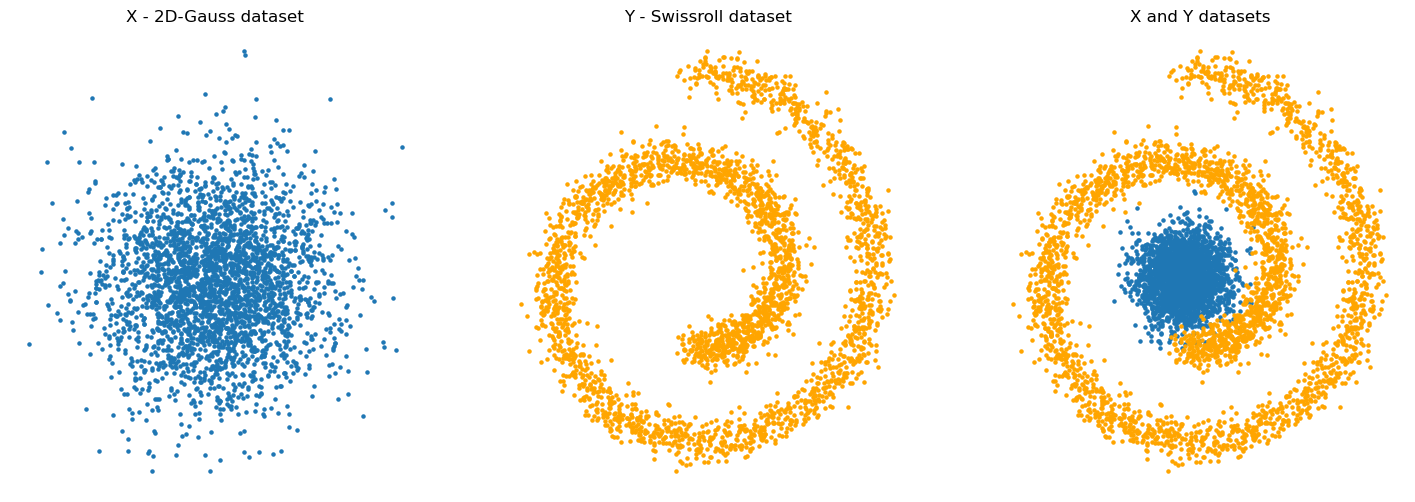

In [141]:
dataset_x = GaussDataset(n_samples=3000, sigma=1.5)
dataset_y = SwissrollDataset(n_samples=3000)

_, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].scatter(dataset_x.data[:, 0].cpu(), dataset_x.data[:, 1].cpu(), s=5, marker='o')
axs[0].set_title("X - 2D-Gauss dataset")
axs[0].axis('off')

axs[1].scatter(dataset_y.data[:, 0].cpu(), dataset_y.data[:, 1].cpu(), c='orange', s=5, marker='o')
axs[1].set_title("Y - Swissroll dataset")
axs[1].axis('off')

axs[2].scatter(dataset_x.data[:, 0].cpu(), dataset_x.data[:, 1].cpu(), s=5, marker='o')
axs[2].scatter(dataset_y.data[:, 0].cpu(), dataset_y.data[:, 1].cpu(), c='orange', s=5, marker='o')
axs[2].set_title("X and Y datasets")
axs[2].axis('off')

plt.show()

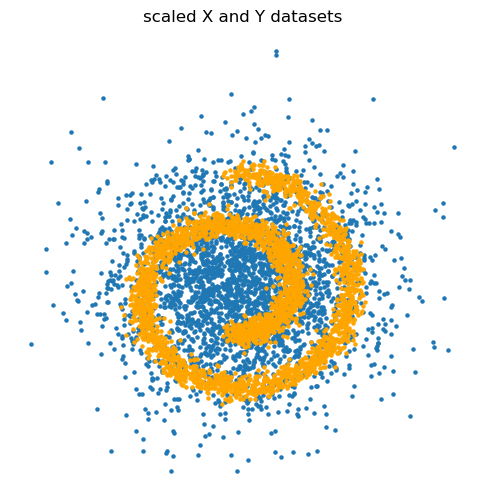

In [144]:
# scaled version overview (maybe will work better?)
plt.figure(figsize=(6, 6))

scaled_ds_x = std_scale(dataset_x.data, dataset_x.mu, dataset_x.std)

scaled_ds_y = std_scale(dataset_y.data, dataset_y.mu, dataset_y.std)

plt.scatter(scaled_ds_x[:, 0].cpu(), scaled_ds_x[:, 1].cpu(), s=5, marker='o')
plt.scatter(scaled_ds_y[:, 0].cpu(), scaled_ds_y[:, 1].cpu(), c='orange', s=5, marker='o')
plt.title("scaled X and Y datasets")
plt.axis('off')

plt.show()

### Models, Langevin, Training procedure

Hyperparameters for sampling

In [223]:
N_SAMPLES=200
EPS=1e-2

# try to reduce bias?
U_STEP_SIZE=3e-4
U_N_STEPS=200
U_SIGMA_0=1.

V_STEP_SIZE=1e-3
V_N_STEPS=100
V_SIGMA_0=1.

SCALED_REGIME=True

ALPHA=1e-2

dataset_x.sample_scaled = SCALED_REGIME
dataset_y.sample_scaled = SCALED_REGIME

In [224]:
class BasicMLP(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.mlp = nn.Sequential( # just threw some linear
            nn.Linear(2, hidden_dim//2),
            nn.ELU(),
            nn.Linear(hidden_dim//2, hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ELU(),
            nn.Linear(hidden_dim//2, 2),
            # nn.ReLU() # needed component? [0, + inf) # log: no observable effect
        )

    def forward(self, x):
        return self.mlp(x)


class BasicModel(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.mlp = BasicMLP(hidden_dim)

    def forward(self, x):
        return self.mlp(x)


def c(x, y):
    """Wasserstein-2 distance"""
    return 0.5*torch.pow(torch.norm(x - y), 2)


class CostWrapper:
    """Utility class to store up additional arguments for cost function calls"""
    def __init__(self, args):
        self.args = args

    def __call__(self, x):
        return c(x, self.args)

    def grad(self, x):
         return x - self.args


def langevin_sampling(model: nn.Module, num_samples: int, cost: CostWrapper, num_steps, step_size, sigma_0, decay=1.):
    x = torch.normal(0, sigma_0, size=(num_samples, 2), device=DEVICE)
    noise = step_size**0.5
    for _ in range(num_steps):
        # compute grad of model output w.r.t input
        with torch.enable_grad():
            x.requires_grad_(True)
            outp = model(x)
            outp_grad = autograd.grad(
                outputs=outp,
                inputs=x,
                grad_outputs=torch.ones_like(outp),
                create_graph=True,
                retain_graph=True
            )[0]

            c_grad = cost.grad(x) # this works fine

        z = torch.normal(0, 1, size=x.shape, device=DEVICE)

        # perform langevin step
        x = x + 0.5 * step_size * (outp_grad - c_grad/EPS) + noise * z
        
        step_size *= decay
        noise *= decay**0.5

    return x


def sample_from_joint_pi_theta(u_model, v_model, x_true, y_true):
    u_model.eval()
    v_model.eval()
    with torch.no_grad():
        y_sampled = langevin_sampling(
            u_model, 
            num_samples=N_SAMPLES, 
            cost=CostWrapper(x_true), 
            num_steps=U_N_STEPS, 
            step_size=U_STEP_SIZE, 
            sigma_0=U_SIGMA_0
        )
        x_sampled = langevin_sampling(
            v_model, 
            num_samples=N_SAMPLES,
            cost=CostWrapper(y_true), 
            num_steps=V_N_STEPS, 
            step_size=V_STEP_SIZE,
            sigma_0=V_SIGMA_0
        )
    u_model.train()
    v_model.train()
    return x_sampled, y_sampled


def train(dataset_x, dataset_y, u_model, v_model, optimizer, num_iters=200):
    u_model.train()
    v_model.train()
    loss_hist = []

    with tqdm(range(num_iters), unit='iter') as titer:
        for _ in titer:
            optimizer.zero_grad()
            x_samples_true = dataset_x.sample(N_SAMPLES)
            y_samples_true = dataset_y.sample(N_SAMPLES)
            
            x_samples_lg, y_samples_lg = sample_from_joint_pi_theta(
                u_model, v_model,
                x_samples_true, y_samples_true
            )

            pos_y_out = u_model(x_samples_true)
            pos_x_out = v_model(y_samples_true)
            neg_y_out = u_model(x_samples_lg)
            neg_x_out = v_model(y_samples_lg)

            loss = - pos_y_out.mean() - pos_x_out.mean() \
            + neg_y_out.mean() + neg_x_out.mean()
            # some sort of regularization I found in code, it helps, but dk why
            loss += ALPHA*(torch.pow(pos_y_out, 2) + torch.pow(pos_x_out, 2) + torch.pow(neg_y_out, 2) + torch.pow(neg_x_out, 2)).mean()


            loss.backward()
            optimizer.step()

            loss_hist.append(loss.item())
            titer.set_postfix(loss=loss_hist[-1])

    return loss_hist


In [239]:
NUM_ITERS=1000
LR=5e-4
HIDDEN_DIM_SIZE=128

In [240]:
u_model = BasicModel(hidden_dim=HIDDEN_DIM_SIZE).to(DEVICE)
v_model = BasicModel(hidden_dim=HIDDEN_DIM_SIZE).to(DEVICE)

optimizer = torch.optim.SGD(list(u_model.parameters()) + list(v_model.parameters()), lr=LR)
loss_hist = train(dataset_x, dataset_y, u_model, v_model, optimizer, num_iters=NUM_ITERS)

100%|██████████| 1000/1000 [07:39<00:00,  2.18iter/s, loss=-.072]  


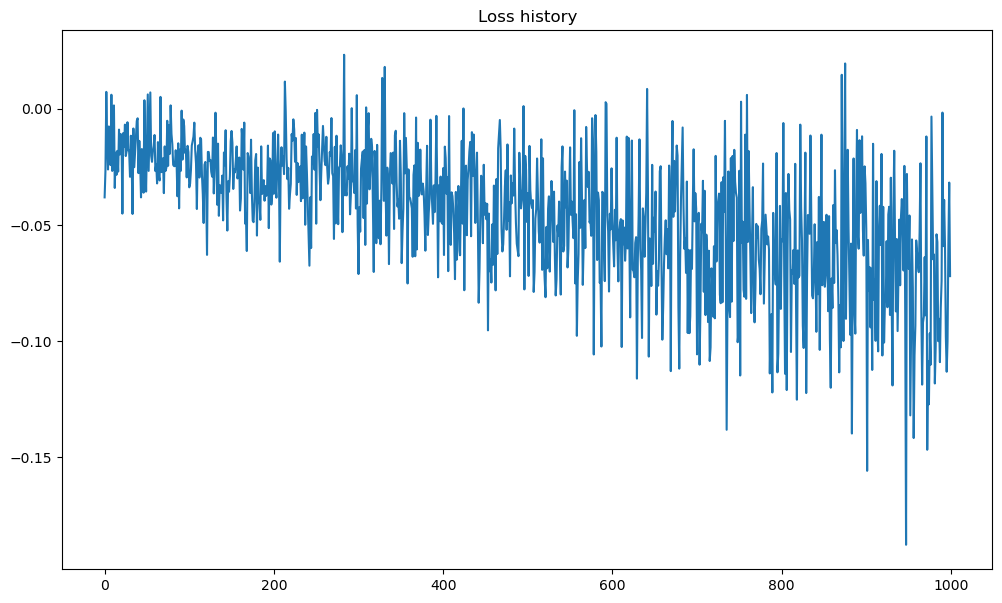

In [241]:
plt.figure(figsize=(12, 7))
plt.plot(loss_hist)
plt.title("Loss history")
plt.show()

In [242]:
# torch.save(u_model.state_dict(), 'models/u_model_1000.pth')
# torch.save(v_model.state_dict(), 'models/v_model_1000.pth')

### Results

If you want to test pretrained model, execute following cell (note - you should also execute cells with hyperparameters definitions):

In [ ]:
u_model = BasicModel(hidden_dim=128).load_state_dict(torch.load('models/u_model_1000.pth'))
v_model = BasicModel(hidden_dim=128).load_state_dict(torch.load('models/v_model_1000.pth'))

Following code demonstrates sampling from distribution conditioned on single point from other domain.

In [243]:
def sample_from_model(model, x_start, n_samples, sampling_params):
    x_start = torch.broadcast_to(x_start, (n_samples, 2))
    if sampling_params == "U":
        y_sampled = langevin_sampling(
            model, 
            n_samples, 
            CostWrapper(x_start), 
            num_steps=U_N_STEPS, 
            step_size=U_STEP_SIZE, 
            sigma_0=U_SIGMA_0
        )
    elif sampling_params == "V":
        y_sampled = langevin_sampling(
            model, 
            n_samples, 
            CostWrapper(x_start), 
            num_steps=V_N_STEPS, 
            step_size=V_STEP_SIZE, 
            sigma_0=V_SIGMA_0
        )
    return y_sampled


def visualize_sampling(model, dataset1, dataset2, samples=100, swap_colors=False, scale_axis=False, title="Sampling from model", sampling_params=None):
    x_start = dataset1.sample(1)
    #x_start = torch.tensor([[5, 5]]).to(DEVICE)
    y_sampled = sample_from_model(model, x_start, samples, sampling_params)

    if SCALED_REGIME:
        x_start = std_scale_inv(x_start, dataset1.mu, dataset1.std)
        y_sampled = std_scale_inv(y_sampled, dataset2.mu, dataset2.std)

    x_start = x_start.cpu().detach().numpy()
    y_sampled = y_sampled.cpu().detach().numpy()

    c1, c2 = ('skyblue', 'orange') if not swap_colors else ('orange', 'skyblue')

    ds1_data = dataset1.data
    ds2_data = dataset2.data
    
    plt.figure(figsize=(8, 8))
    plt.scatter(ds1_data[:, 0].cpu(), ds1_data[:, 1].cpu(), c=c1, s=5, marker='o', alpha=0.2)
    plt.scatter(ds2_data[:, 0].cpu(), ds2_data[:, 1].cpu(), c=c2, s=5, marker='o', alpha=0.2)

    plt.scatter(x_start[:, 0], x_start[:, 1], c='red', s=50, marker='o')
    plt.scatter(y_sampled[:, 0], y_sampled[:, 1], c='red', s=25, marker='x')

    for i in range(len(y_sampled)):
        plt.plot([x_start[0, 0], y_sampled[i, 0]], [x_start[0, 1], y_sampled[i, 1]], c='red', alpha=0.2)

    if scale_axis:
        # scale plt around sampled points
        x_min = np.min(y_sampled[:, 0])
        x_max = np.max(y_sampled[:, 0])
        y_min = np.min(y_sampled[:, 1])
        y_max = np.max(y_sampled[:, 1])

        plt.xlim(x_min - 0.1*(x_max - x_min), x_max + 0.1*(x_max - x_min))
        plt.ylim(y_min - 0.1*(y_max - y_min), y_max + 0.1*(y_max - y_min))

    plt.title(title)
    plt.show()

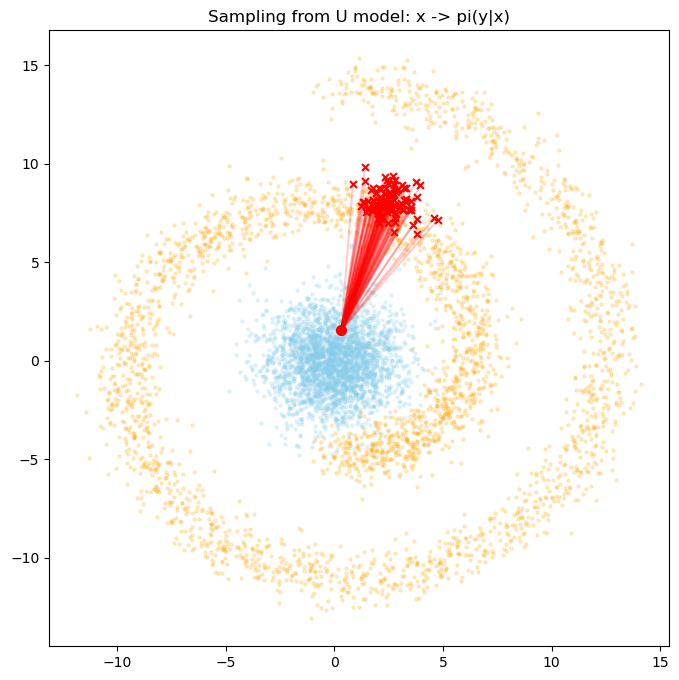

In [254]:
visualize_sampling(u_model, dataset_x, dataset_y, title="Sampling from U model: x -> pi(y|x)", sampling_params="U")

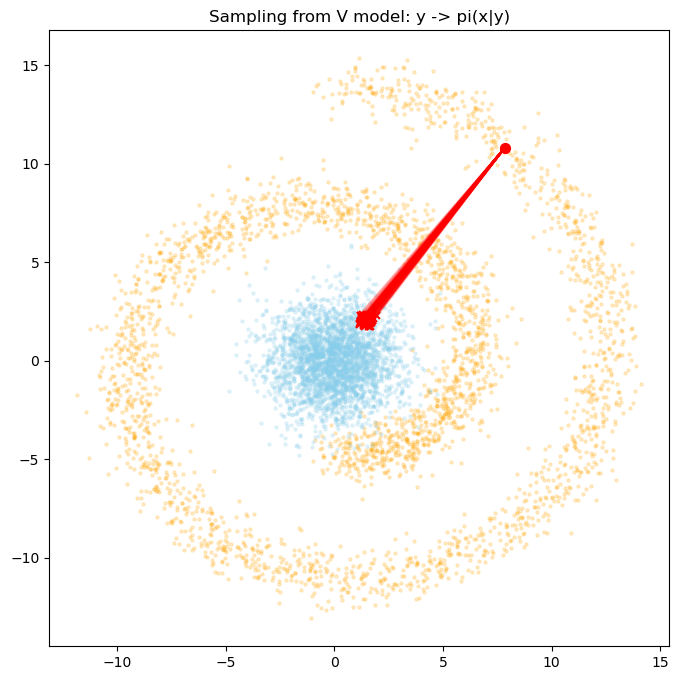

In [257]:
visualize_sampling(v_model, dataset_y, dataset_x, swap_colors=True, sampling_params="V", title="Sampling from V model: y -> pi(x|y)")

### Conclusion

So, on our Toy example we've learned joint optimal plan, which allows us to conditionally sample from x to y and from y to x, while training fully in unsupervised regime, which is very cool.

Main concernes:

- SCALED_REGIME is a game changer, without it thing didn't learn at all
- learned x -> pi(|x) is very unstable (from gauss to swissroll), don't really know why
- Loss dynamics don't show any convergence towards zero, but I expected this kind of behaviour